In [8]:
import numpy as np
import numba
import matplotlib.pyplot as plt

In [14]:
# Physical constants
a0 = 1.0  # unit of length (e.g., bohr)
Ha = 1.0  # unit of energy

# Exact wave functions
def psi_100(r):
    return 2.0 * np.exp(-r)

def psi_200(r):
    return (1 / np.sqrt(2)) * (2 - r) * np.exp(-r / 2)


In [15]:
# Trial wave function
@numba.njit
def psi_trial(r, a, c):
    return (1 + c * r) * np.exp(-a * r)

# Local energy
@numba.njit
def local_energy(r, a, c):
    kinetic = -0.5 * (a**2 * c * r**2 + (2 * a - 2 * c) * r)
    potential = -1 / r
    return (kinetic + potential) * psi_trial(r, a, c) / psi_trial(r, a, c)

# Monte Carlo integration function for energy calculations
@numba.njit
def monte_carlo_integration_energy(a, c, delta_r, N):
    energy_sum = 0.0
    energy_squared_sum = 0.0
    r_values = []

    r = 0.5  # Starting point
    for i in range(N):
        r_new = r + delta_r * (2 * np.random.random() - 1)
        if r_new > 0:
            p_acc = min(1, psi_trial(r_new, a, c)**2 / psi_trial(r, a, c)**2)
            if np.random.random() < p_acc:
                r = r_new
        r_values.append(r)

    r_values = np.array(r_values)

    for r in r_values:
        local_en = local_energy(r, a, c)
        energy_sum += local_en
        energy_squared_sum += local_en**2

    average_energy = energy_sum / N
    variance = energy_squared_sum / N - average_energy**2
    error = np.sqrt(variance / N)

    return average_energy, error, r_values

In [3]:
# Parametry całkowania Monte Carlo
N = 10**6   # liczba próbek
delta_r = 0.1

# Zakres parametrów a i c
a_values = np.arange(0.3, 1.21, 0.02)
c_values = np.arange(-0.7, 0.31, 0.02)

# Tablice do przechowywania wyników
energy_results = np.zeros((len(a_values), len(c_values)))
variance_results = np.zeros((len(a_values), len(c_values)))

# Obliczenia dla różnych kombinacji a i c
for i, a in enumerate(a_values):
    for j, c in enumerate(c_values):
        avg_energy, error, _ = monte_carlo_integration(a, c, delta_r, N)
        energy_results[i, j] = avg_energy
        variance_results[i, j] = error

In [16]:
# Monte Carlo integration function for histogram generation
def monte_carlo_integration_histogram(delta_r, N):
    r_values = []
    r = 0.5  # Starting point
    for i in range(N):
        r_new = r + delta_r * (2.0 * np.random.rand() - 1.0)
        if r_new < 0:
            r_new = -r_new
        acceptance_prob = min((r_new**2 * psi_100(r_new)**2) / (r**2 * psi_100(r)**2), 1)
        if np.random.rand() < acceptance_prob:
            r = r_new
        r_values.append(r)
    return r_values

# Parameters for energy calculations
N = 10**6  # Number of samples
delta_r = 0.1

# Range of parameters a and c
a_values = np.arange(0.3, 1.21, 0.02)
c_values = np.arange(-0.7, 0.31, 0.02)

# Arrays to store results
energy_results = np.zeros((len(a_values), len(c_values)))
variance_results = np.zeros((len(a_values), len(c_values)))

# Calculations for different combinations of a and c
for i, a in enumerate(a_values):
    for j, c in enumerate(c_values):
        avg_energy, error, _ = monte_carlo_integration_energy(a, c, delta_r, N)
        energy_results[i, j] = avg_energy
        variance_results[i, j] = error

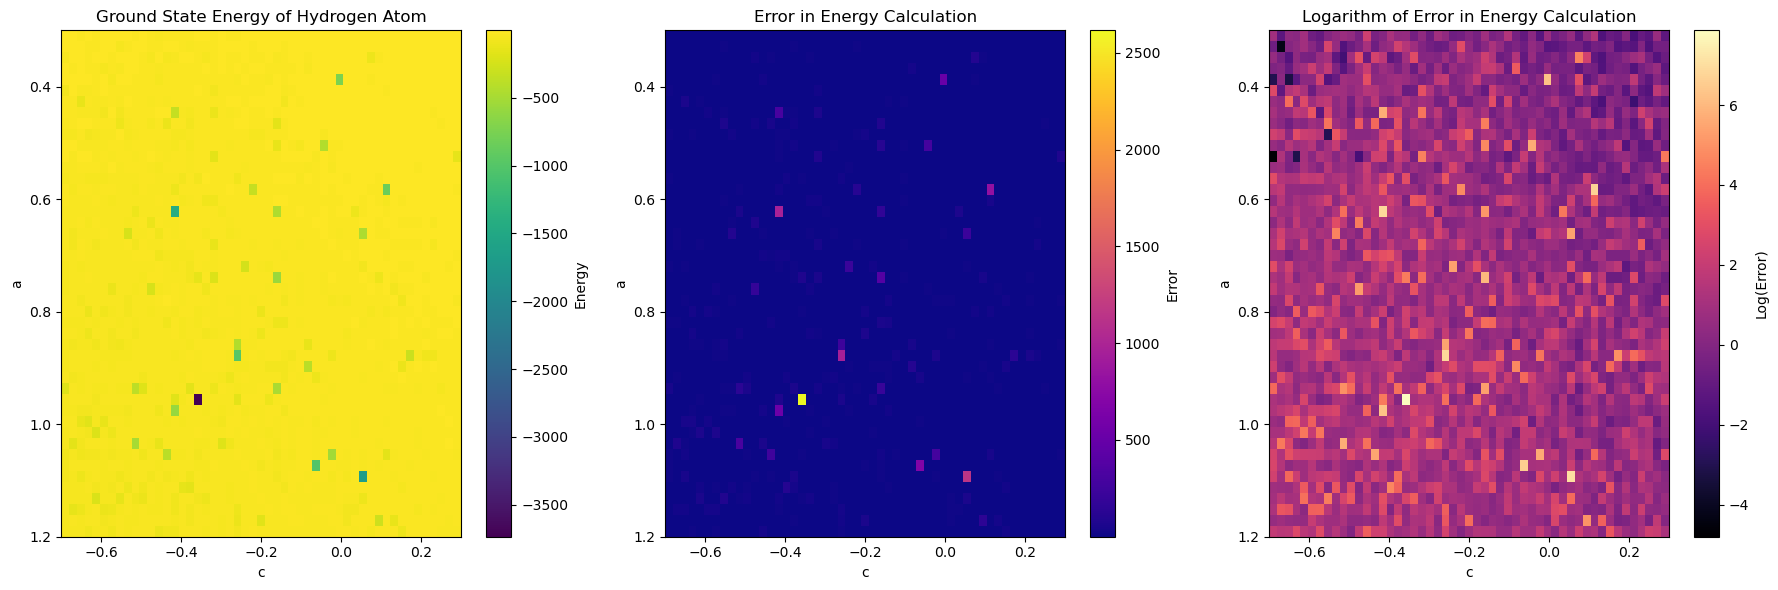

In [17]:
# Plot results for energy and error
plt.figure(figsize=(18, 6))

# 1. Energy plot
plt.subplot(1, 3, 1)
plt.imshow(energy_results, extent=[c_values[0], c_values[-1], a_values[0], a_values[-1]], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Energy')
plt.title('Ground State Energy of Hydrogen Atom')
plt.xlabel('c')
plt.ylabel('a')
plt.gca().invert_yaxis()

# 2. Standard deviation plot
plt.subplot(1, 3, 2)
plt.imshow(variance_results, extent=[c_values[0], c_values[-1], a_values[0], a_values[-1]], origin='lower', aspect='auto', cmap='plasma')
plt.colorbar(label='Error')
plt.title('Error in Energy Calculation')
plt.xlabel('c')
plt.ylabel('a')
plt.gca().invert_yaxis()

# 3. Logarithm of standard deviation plot
log_variance = np.log(variance_results + 1e-20)
plt.subplot(1, 3, 3)
plt.imshow(log_variance, extent=[c_values[0], c_values[-1], a_values[0], a_values[-1]], origin='lower', aspect='auto', cmap='magma')
plt.colorbar(label='Log(Error)')
plt.title('Logarithm of Error in Energy Calculation')
plt.xlabel('c')
plt.ylabel('a')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

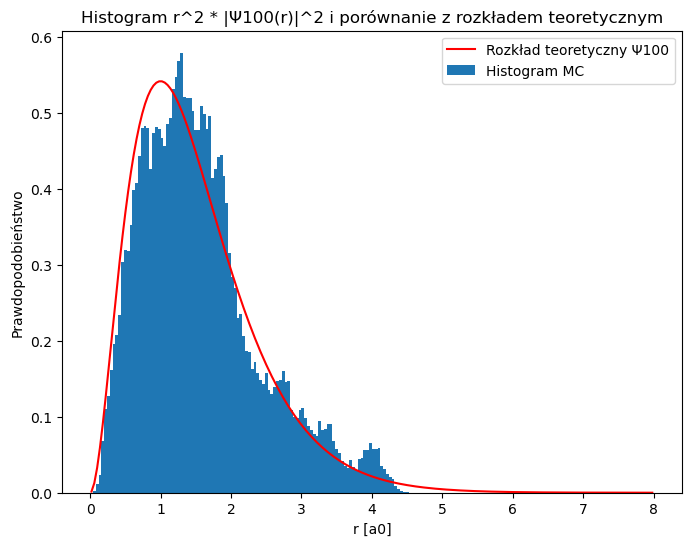

In [18]:
# Parameters for histogram
M = 200
r_max = 8.0
delta_r_hist = r_max / M
N_hist = 10**5  # Number of samples for histogram

# Perform Monte Carlo integration for histogram
r_values = monte_carlo_integration_histogram(delta_r_hist, N_hist)

# Compute histogram
hist, bin_edges = np.histogram(r_values, bins=M, range=(0, r_max), density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Theoretical distributions
exact_distribution_100 = bin_centers**2 * psi_100(bin_centers)**2

# Plot histogram for psi_100
plt.figure(figsize=(8, 6))
plt.bar(bin_centers, hist, width=delta_r_hist, label='Histogram MC')
plt.plot(bin_centers, exact_distribution_100, 'r-', label='Rozkład teoretyczny Ψ100')
plt.xlabel('r [a0]')
plt.ylabel('Prawdopodobieństwo')
plt.title('Histogram r^2 * |Ψ100(r)|^2 i porównanie z rozkładem teoretycznym')
plt.legend()
plt.savefig('histogram_psi_100.png')
plt.show()